In [3]:
pip install matplotlib

  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl (225 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from PIL import Image
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import time

# For downloading the dataset
import requests
import tarfile
from io import BytesIO

In [3]:
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    DATASET_NAME = "facades"
    
    # --- THIS IS THE UPDATED PATH ---
    # It needs to include the *second* 'facades' folder
    ROOT_DIR = r"D:\ProdigyInfotechInternship\Task4\PRDOIGY_GA_04\data\facades\facades"
    
    TRAIN_DIR = os.path.join(ROOT_DIR, "train")
    VAL_DIR = os.path.join(ROOT_DIR, "val")
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 1 # In the pix2pix paper, batch size is 1
    NUM_EPOCHS = 200 # The paper trains for 200 epochs
    L1_LAMBDA = 100
    IMG_SIZE = 256
    
cfg = Config()

print(f"Using device: {cfg.DEVICE}")
print(f"Data root set to: {cfg.ROOT_DIR}")

# --- Verification ---
# Now, this check should pass
print(f"Train directory exists: {os.path.exists(cfg.TRAIN_DIR)}")
print(f"Validation directory exists: {os.path.exists(cfg.VAL_DIR)}")

Using device: cuda
Data root set to: D:\ProdigyInfotechInternship\Task4\PRDOIGY_GA_04\data\facades\facades
Train directory exists: True
Validation directory exists: True


In [4]:
### CELL 4 (Corrected) ###

class FacadesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Get all image file names
        self.files = sorted([f for f in os.listdir(root_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_file = self.files[idx]
        img_path = os.path.join(self.root_dir, img_file)
        
        # Load the composite image
        image = Image.open(img_path).convert("RGB")
        
        width, height = image.size
        
        # --- HERE IS THE FIX ---
        # The Input (x) is the Map (right side)
        input_image = image.crop((width // 2, 0, width, height)) 
        
        # The Real/Target (y) is the Photo (left side)
        real_image = image.crop((0, 0, width // 2, height))
        # --- END FIX ---

        if self.transform:
            # We must apply the *same* random transformations
            state = torch.get_rng_state()
            input_image = self.transform(input_image)
            torch.set_rng_state(state)
            real_image = self.transform(real_image)

        return input_image, real_image

In [5]:
# --- Transforms (Data Augmentation / Jitter) ---
# As per the paper: 1. Resize to 286x286, 2. Randomly crop to 256x256, 3. Random horizontal flip
train_transform = transforms.Compose([
    transforms.Resize((286, 286), transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # Normalize to [-1, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    # Normalize to [-1, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


# --- Create DataLoaders ---
train_dataset = FacadesDataset(root_dir=cfg.TRAIN_DIR, transform=train_transform)
train_loader = DataLoader(
    train_dataset, 
    batch_size=cfg.BATCH_SIZE, 
    shuffle=True, 
    num_workers=0, # Use multiple workers to load data faster
    pin_memory=True # Speeds up host-to-device transfer
)

val_dataset = FacadesDataset(root_dir=cfg.VAL_DIR, transform=val_transform)
val_loader = DataLoader(
    val_dataset, 
    batch_size=1, # We'll validate on single images
    shuffle=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 400
Validation batches: 100


In [6]:
# --- Helper: Encoder/Decoder Block ---
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

# --- Build the U-Net Generator ---
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        
        # --- Encoder (Down-sampling) ---
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        ) # 256 -> 128
        
        self.down1 = Block(features, features * 2, down=True, act="leaky") # 128 -> 64
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky") # 64 -> 32
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky") # 32 -> 16
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky") # 16 -> 8
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky") # 8 -> 4
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky") # 4 -> 2
        
        # --- Bottleneck ---
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode="reflect"), # 2 -> 1
            nn.ReLU(),
        )

        # --- Decoder (Up-sampling) ---
        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu")
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu")
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu")
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu")
        
        # --- Final Layer ---
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1),
            nn.Tanh(), # Output images are in [-1, 1]
        )

    def forward(self, x):
        # Pass through encoder, saving outputs for skip connections
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        
        bottleneck = self.bottleneck(d7)
        
        # Pass through decoder, concatenating skip connections
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], dim=1)) # Skip connection
        up3 = self.up3(torch.cat([up2, d6], dim=1)) # Skip connection
        up4 = self.up4(torch.cat([up3, d5], dim=1)) # Skip connection
        up5 = self.up5(torch.cat([up4, d4], dim=1)) # Skip connection
        up6 = self.up6(torch.cat([up5, d3], dim=1)) # Skip connection
        up7 = self.up7(torch.cat([up6, d2], dim=1)) # Skip connection
        
        return self.final_up(torch.cat([up7, d1], dim=1)) # Final skip connection

print("Generator definition complete.")

Generator definition complete.


In [7]:
# --- Helper: Discriminator Convolution Block ---
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.conv(x)

# --- Build the PatchGAN Discriminator ---
class Discriminator(nn.Module):
    # in_channels will be 6 (3 for input img + 3 for real/fake img)
    def __init__(self, in_channels=6, features=[64, 128, 256, 512]):
        super().__init__()
        
        # This model follows the PatchGAN C64-C128-C256-C512 structure
        self.model = nn.Sequential(
            # initial block (no BatchNorm)
            nn.Conv2d(in_channels, features[0], 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
            
            # C128
            CNNBlock(features[0], features[1], stride=2),
            # C256
            CNNBlock(features[1], features[2], stride=2),
            # C512 (stride 1)
            CNNBlock(features[2], features[3], stride=1), 
            
            # Final 1-filter convolution to produce the 30x30 patch output
            nn.Conv2d(features[3], 1, 4, 1, 1, padding_mode="reflect")
        )

    def forward(self, x, y):
        # Concatenate x (input) and y (real/fake) along the channel dim
        x = torch.cat([x, y], dim=1)
        return self.model(x)

print("Discriminator definition complete.")

Discriminator definition complete.


In [8]:
# --- Initialize Models ---
gen = Generator(in_channels=3, out_channels=3).to(cfg.DEVICE)
disc = Discriminator(in_channels=6).to(cfg.DEVICE)

# --- Define Optimizers ---
opt_gen = optim.Adam(gen.parameters(), lr=cfg.LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=cfg.LEARNING_RATE, betas=(0.5, 0.999))

# --- Define Loss Functions ---
# Adversarial Loss
BCE_loss = nn.BCEWithLogitsLoss() # This is more numerically stable than BCE + Sigmoid

# L1 (Content) Loss
L1_loss = nn.L1Loss() # Mean Absolute Error

print("Models, losses, and optimizers initialized.")

Models, losses, and optimizers initialized.


In [9]:
def train_step(disc, gen, batch, opt_disc, opt_gen, bce, l1):
    """
    Performs a single training step (one batch) for both models.
    """
    x, y = batch
    x, y = x.to(cfg.DEVICE), y.to(cfg.DEVICE)
    
    # --- 1. Train Discriminator ---
    opt_disc.zero_grad()

    # Real images
    D_real = disc(x, y)
    D_real_loss = bce(D_real, torch.ones_like(D_real))
    
    # Fake images
    G_fake = gen(x).detach()
    D_fake = disc(x, G_fake)
    D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
    
    # Total Discriminator loss
    D_loss = (D_real_loss + D_fake_loss) / 2
    
    # Backprop
    D_loss.backward()
    opt_disc.step()

    # --- 2. Train Generator ---
    opt_gen.zero_grad()

    # Generate fake image
    G_fake = gen(x)
    # Pass through discriminator
    D_fake = disc(x, G_fake)
    
    # Adversarial loss (try to fool discriminator)
    G_adv_loss = bce(D_fake, torch.ones_like(D_fake))
    # L1 (content) loss
    G_l1_loss = l1(G_fake, y) * cfg.L1_LAMBDA
    
    # Total Generator loss
    G_loss = G_adv_loss + G_l1_loss
    
    # Backprop
    G_loss.backward()
    opt_gen.step()
    
    return D_loss.item(), G_loss.item()

print("train_step function defined.")

train_step function defined.


In [10]:
# Create a directory to save output images
os.makedirs("outputs", exist_ok=True)

def generate_and_save_images(gen_model, loader, epoch):
    """Saves a grid of generated images"""
    gen_model.eval() # Set to evaluation mode
    
    with torch.no_grad():
        # Get one batch from the validation loader
        for input_img, target_img in loader:
            input_img, target_img = input_img.to(cfg.DEVICE), target_img.to(cfg.DEVICE)
            
            # Generate fake image
            fake_img = gen_model(input_img)
            
            # Denormalize from [-1, 1] to [0, 1]
            input_img_plot = input_img * 0.5 + 0.5
            target_img_plot = target_img * 0.5 + 0.5
            fake_img_plot = fake_img * 0.5 + 0.5
            
            # Create a grid: [Input, Generated, Real]
            # We use `make_grid` to arrange them.
            # Stack them along the batch dimension to make a 3x... grid
            combined_images = torch.cat([input_img_plot, fake_img_plot, target_img_plot], dim=0)
            
            # Save the image
            save_path = f"outputs/epoch_{epoch+1:03d}.png"
            save_image(combined_images, save_path, nrow=3) # 3 images per row
            
            # We only need one batch for visualization
            break
            
    gen_model.train() # Set back to train mode

print("generate_and_save_images function defined.")

generate_and_save_images function defined.


In [11]:
from tqdm.notebook import tqdm # Import tqdm for a nice progress bar

print("Starting training... 🚀")

# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(cfg.NUM_EPOCHS):
    start_time = time.time()
    
    epoch_d_losses = []
    epoch_g_losses = []

    # --- Training Phase ---
    gen.train()
    disc.train()
    
    # Add a progress bar for the training loader
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{cfg.NUM_EPOCHS}]", leave=True)
    
    for batch_idx, (x, y) in enumerate(loop):
        batch = (x, y)
        d_loss, g_loss = train_step(disc, gen, batch, opt_disc, opt_gen, BCE_loss, L1_loss)
        
        epoch_d_losses.append(d_loss)
        epoch_g_losses.append(g_loss)

        # Update progress bar description
        loop.set_postfix(D_loss=d_loss, G_loss=g_loss)

    # Get average losses for the epoch
    avg_d_loss = np.mean(epoch_d_losses)
    avg_g_loss = np.mean(epoch_g_losses)
    D_losses.append(avg_d_loss)
    G_losses.append(avg_g_loss)
    
    end_time = time.time()
    
    # --- Logging and Visualization ---
    print(f"--- Epoch {epoch+1}/{cfg.NUM_EPOCHS} ---")
    print(f"Time: {end_time - start_time:.2f}s")
    print(f"Avg. Discriminator Loss: {avg_d_loss:.4f}")
    print(f"Avg. Generator Loss: {avg_g_loss:.4f}")

    # Generate and save test images (e.g., every 5 epochs)
    if (epoch + 1) % 5 == 0:
        print(f"Saving validation image for epoch {epoch+1}...")
        generate_and_save_images(gen, val_loader, epoch)
        
    # (Optional) Save model checkpoints
    # if (epoch + 1) % 25 == 0:
    #     os.makedirs("checkpoints", exist_ok=True)
    #     torch.save(gen.state_dict(), f"checkpoints/gen_epoch_{epoch+1}.pth")
    #     torch.save(disc.state_dict(), f"checkpoints/disc_epoch_{epoch+1}.pth")

print("Training complete. 🎉")

Starting training... 🚀


Epoch [1/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 1/200 ---
Time: 14.24s
Avg. Discriminator Loss: 0.4982
Avg. Generator Loss: 37.6906


Epoch [2/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 2/200 ---
Time: 13.74s
Avg. Discriminator Loss: 0.4221
Avg. Generator Loss: 36.3197


Epoch [3/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 3/200 ---
Time: 14.14s
Avg. Discriminator Loss: 0.3256
Avg. Generator Loss: 36.6209


Epoch [4/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 4/200 ---
Time: 14.15s
Avg. Discriminator Loss: 0.3092
Avg. Generator Loss: 36.8198


Epoch [5/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 5/200 ---
Time: 14.42s
Avg. Discriminator Loss: 0.3525
Avg. Generator Loss: 36.4246
Saving validation image for epoch 5...


Epoch [6/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 6/200 ---
Time: 14.93s
Avg. Discriminator Loss: 0.3276
Avg. Generator Loss: 36.6559


Epoch [7/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 7/200 ---
Time: 14.30s
Avg. Discriminator Loss: 0.3056
Avg. Generator Loss: 37.1683


Epoch [8/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 8/200 ---
Time: 15.24s
Avg. Discriminator Loss: 0.3036
Avg. Generator Loss: 36.8617


Epoch [9/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 9/200 ---
Time: 15.10s
Avg. Discriminator Loss: 0.3026
Avg. Generator Loss: 37.1040


Epoch [10/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 10/200 ---
Time: 14.82s
Avg. Discriminator Loss: 0.3599
Avg. Generator Loss: 36.7560
Saving validation image for epoch 10...


Epoch [11/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 11/200 ---
Time: 14.95s
Avg. Discriminator Loss: 0.3092
Avg. Generator Loss: 36.5915


Epoch [12/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 12/200 ---
Time: 15.34s
Avg. Discriminator Loss: 0.3139
Avg. Generator Loss: 36.6675


Epoch [13/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 13/200 ---
Time: 14.99s
Avg. Discriminator Loss: 0.3112
Avg. Generator Loss: 36.4275


Epoch [14/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 14/200 ---
Time: 14.50s
Avg. Discriminator Loss: 0.3421
Avg. Generator Loss: 36.1035


Epoch [15/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 15/200 ---
Time: 14.96s
Avg. Discriminator Loss: 0.3720
Avg. Generator Loss: 36.2200
Saving validation image for epoch 15...


Epoch [16/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 16/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3406
Avg. Generator Loss: 35.6950


Epoch [17/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 17/200 ---
Time: 14.38s
Avg. Discriminator Loss: 0.3695
Avg. Generator Loss: 35.8471


Epoch [18/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 18/200 ---
Time: 14.67s
Avg. Discriminator Loss: 0.3434
Avg. Generator Loss: 35.8519


Epoch [19/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 19/200 ---
Time: 14.64s
Avg. Discriminator Loss: 0.3630
Avg. Generator Loss: 35.7749


Epoch [20/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 20/200 ---
Time: 14.42s
Avg. Discriminator Loss: 0.3642
Avg. Generator Loss: 35.3085
Saving validation image for epoch 20...


Epoch [21/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 21/200 ---
Time: 14.74s
Avg. Discriminator Loss: 0.3629
Avg. Generator Loss: 35.2851


Epoch [22/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 22/200 ---
Time: 14.08s
Avg. Discriminator Loss: 0.3656
Avg. Generator Loss: 35.0274


Epoch [23/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 23/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3677
Avg. Generator Loss: 34.9695


Epoch [24/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 24/200 ---
Time: 14.73s
Avg. Discriminator Loss: 0.3660
Avg. Generator Loss: 34.7953


Epoch [25/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 25/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3714
Avg. Generator Loss: 34.6661
Saving validation image for epoch 25...


Epoch [26/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 26/200 ---
Time: 13.94s
Avg. Discriminator Loss: 0.3611
Avg. Generator Loss: 34.5887


Epoch [27/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 27/200 ---
Time: 14.91s
Avg. Discriminator Loss: 0.3733
Avg. Generator Loss: 34.3696


Epoch [28/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 28/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3551
Avg. Generator Loss: 34.1959


Epoch [29/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 29/200 ---
Time: 14.64s
Avg. Discriminator Loss: 0.3630
Avg. Generator Loss: 34.4910


Epoch [30/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 30/200 ---
Time: 14.35s
Avg. Discriminator Loss: 0.3664
Avg. Generator Loss: 34.0034
Saving validation image for epoch 30...


Epoch [31/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 31/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3514
Avg. Generator Loss: 33.6581


Epoch [32/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 32/200 ---
Time: 14.76s
Avg. Discriminator Loss: 0.3599
Avg. Generator Loss: 33.6983


Epoch [33/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 33/200 ---
Time: 14.11s
Avg. Discriminator Loss: 0.3494
Avg. Generator Loss: 33.4842


Epoch [34/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 34/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3769
Avg. Generator Loss: 33.3205


Epoch [35/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 35/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3664
Avg. Generator Loss: 33.2633
Saving validation image for epoch 35...


Epoch [36/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 36/200 ---
Time: 14.54s
Avg. Discriminator Loss: 0.3602
Avg. Generator Loss: 33.0247


Epoch [37/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 37/200 ---
Time: 14.20s
Avg. Discriminator Loss: 0.3637
Avg. Generator Loss: 32.8863


Epoch [38/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 38/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3752
Avg. Generator Loss: 32.9639


Epoch [39/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 39/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3553
Avg. Generator Loss: 32.7848


Epoch [40/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 40/200 ---
Time: 14.70s
Avg. Discriminator Loss: 0.3748
Avg. Generator Loss: 32.5667
Saving validation image for epoch 40...


Epoch [41/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 41/200 ---
Time: 14.03s
Avg. Discriminator Loss: 0.3876
Avg. Generator Loss: 32.2695


Epoch [42/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 42/200 ---
Time: 14.82s
Avg. Discriminator Loss: 0.3712
Avg. Generator Loss: 32.0045


Epoch [43/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 43/200 ---
Time: 14.95s
Avg. Discriminator Loss: 0.3738
Avg. Generator Loss: 31.7101


Epoch [44/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 44/200 ---
Time: 14.97s
Avg. Discriminator Loss: 0.3588
Avg. Generator Loss: 31.7540


Epoch [45/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 45/200 ---
Time: 13.96s
Avg. Discriminator Loss: 0.3746
Avg. Generator Loss: 31.9173
Saving validation image for epoch 45...


Epoch [46/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 46/200 ---
Time: 14.74s
Avg. Discriminator Loss: 0.3750
Avg. Generator Loss: 31.5883


Epoch [47/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 47/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3678
Avg. Generator Loss: 31.4271


Epoch [48/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 48/200 ---
Time: 15.02s
Avg. Discriminator Loss: 0.3789
Avg. Generator Loss: 30.9813


Epoch [49/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 49/200 ---
Time: 14.15s
Avg. Discriminator Loss: 0.3688
Avg. Generator Loss: 30.8021


Epoch [50/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 50/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3774
Avg. Generator Loss: 30.9742
Saving validation image for epoch 50...


Epoch [51/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 51/200 ---
Time: 14.84s
Avg. Discriminator Loss: 0.3719
Avg. Generator Loss: 30.5860


Epoch [52/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 52/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3797
Avg. Generator Loss: 30.5473


Epoch [53/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 53/200 ---
Time: 14.38s
Avg. Discriminator Loss: 0.3711
Avg. Generator Loss: 30.6425


Epoch [54/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 54/200 ---
Time: 14.87s
Avg. Discriminator Loss: 0.3741
Avg. Generator Loss: 30.3766


Epoch [55/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 55/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3723
Avg. Generator Loss: 30.0254
Saving validation image for epoch 55...


Epoch [56/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 56/200 ---
Time: 14.02s
Avg. Discriminator Loss: 0.3696
Avg. Generator Loss: 30.0446


Epoch [57/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 57/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3689
Avg. Generator Loss: 29.8614


Epoch [58/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 58/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3825
Avg. Generator Loss: 29.9717


Epoch [59/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 59/200 ---
Time: 14.80s
Avg. Discriminator Loss: 0.3692
Avg. Generator Loss: 29.9364


Epoch [60/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 60/200 ---
Time: 14.10s
Avg. Discriminator Loss: 0.3651
Avg. Generator Loss: 29.6585
Saving validation image for epoch 60...


Epoch [61/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 61/200 ---
Time: 14.92s
Avg. Discriminator Loss: 0.3748
Avg. Generator Loss: 29.4574


Epoch [62/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 62/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3817
Avg. Generator Loss: 29.1398


Epoch [63/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 63/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3705
Avg. Generator Loss: 29.3445


Epoch [64/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 64/200 ---
Time: 13.90s
Avg. Discriminator Loss: 0.3715
Avg. Generator Loss: 28.8826


Epoch [65/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 65/200 ---
Time: 14.72s
Avg. Discriminator Loss: 0.3683
Avg. Generator Loss: 29.1311
Saving validation image for epoch 65...


Epoch [66/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 66/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3758
Avg. Generator Loss: 28.7983


Epoch [67/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 67/200 ---
Time: 14.80s
Avg. Discriminator Loss: 0.3727
Avg. Generator Loss: 28.7269


Epoch [68/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 68/200 ---
Time: 14.75s
Avg. Discriminator Loss: 0.3586
Avg. Generator Loss: 28.6615


Epoch [69/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 69/200 ---
Time: 14.42s
Avg. Discriminator Loss: 0.3828
Avg. Generator Loss: 28.6542


Epoch [70/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 70/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3603
Avg. Generator Loss: 28.2505
Saving validation image for epoch 70...


Epoch [71/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 71/200 ---
Time: 14.59s
Avg. Discriminator Loss: 0.3755
Avg. Generator Loss: 28.4279


Epoch [72/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 72/200 ---
Time: 14.46s
Avg. Discriminator Loss: 0.3481
Avg. Generator Loss: 28.2180


Epoch [73/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 73/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3834
Avg. Generator Loss: 28.0846


Epoch [74/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 74/200 ---
Time: 14.59s
Avg. Discriminator Loss: 0.3674
Avg. Generator Loss: 28.0019


Epoch [75/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 75/200 ---
Time: 14.37s
Avg. Discriminator Loss: 0.3733
Avg. Generator Loss: 27.9683
Saving validation image for epoch 75...


Epoch [76/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 76/200 ---
Time: 14.84s
Avg. Discriminator Loss: 0.3693
Avg. Generator Loss: 27.8100


Epoch [77/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 77/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3711
Avg. Generator Loss: 27.5879


Epoch [78/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 78/200 ---
Time: 14.62s
Avg. Discriminator Loss: 0.3606
Avg. Generator Loss: 27.5302


Epoch [79/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 79/200 ---
Time: 14.17s
Avg. Discriminator Loss: 0.3824
Avg. Generator Loss: 27.4387


Epoch [80/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 80/200 ---
Time: 14.88s
Avg. Discriminator Loss: 0.3597
Avg. Generator Loss: 27.3959
Saving validation image for epoch 80...


Epoch [81/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 81/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3826
Avg. Generator Loss: 27.5003


Epoch [82/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 82/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3637
Avg. Generator Loss: 27.4203


Epoch [83/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 83/200 ---
Time: 14.34s
Avg. Discriminator Loss: 0.3700
Avg. Generator Loss: 27.3924


Epoch [84/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 84/200 ---
Time: 14.84s
Avg. Discriminator Loss: 0.3486
Avg. Generator Loss: 27.2567


Epoch [85/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 85/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3769
Avg. Generator Loss: 27.4371
Saving validation image for epoch 85...


Epoch [86/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 86/200 ---
Time: 14.10s
Avg. Discriminator Loss: 0.3729
Avg. Generator Loss: 26.9945


Epoch [87/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 87/200 ---
Time: 14.80s
Avg. Discriminator Loss: 0.3673
Avg. Generator Loss: 26.9971


Epoch [88/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 88/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3654
Avg. Generator Loss: 26.5922


Epoch [89/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 89/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3861
Avg. Generator Loss: 26.7521


Epoch [90/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 90/200 ---
Time: 14.33s
Avg. Discriminator Loss: 0.3537
Avg. Generator Loss: 26.8688
Saving validation image for epoch 90...


Epoch [91/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 91/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3573
Avg. Generator Loss: 26.6212


Epoch [92/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 92/200 ---
Time: 14.60s
Avg. Discriminator Loss: 0.3777
Avg. Generator Loss: 26.3733


Epoch [93/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 93/200 ---
Time: 14.52s
Avg. Discriminator Loss: 0.3530
Avg. Generator Loss: 26.4583


Epoch [94/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 94/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3697
Avg. Generator Loss: 26.6765


Epoch [95/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 95/200 ---
Time: 14.44s
Avg. Discriminator Loss: 0.3634
Avg. Generator Loss: 26.4791
Saving validation image for epoch 95...


Epoch [96/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 96/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3551
Avg. Generator Loss: 26.2821


Epoch [97/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 97/200 ---
Time: 14.74s
Avg. Discriminator Loss: 0.3610
Avg. Generator Loss: 26.2714


Epoch [98/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 98/200 ---
Time: 14.34s
Avg. Discriminator Loss: 0.3668
Avg. Generator Loss: 26.0819


Epoch [99/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 99/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3621
Avg. Generator Loss: 26.1155


Epoch [100/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 100/200 ---
Time: 14.82s
Avg. Discriminator Loss: 0.3662
Avg. Generator Loss: 26.0600
Saving validation image for epoch 100...


Epoch [101/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 101/200 ---
Time: 14.25s
Avg. Discriminator Loss: 0.3666
Avg. Generator Loss: 25.8275


Epoch [102/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 102/200 ---
Time: 15.24s
Avg. Discriminator Loss: 0.3625
Avg. Generator Loss: 25.8370


Epoch [103/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 103/200 ---
Time: 14.96s
Avg. Discriminator Loss: 0.3555
Avg. Generator Loss: 25.9123


Epoch [104/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 104/200 ---
Time: 14.35s
Avg. Discriminator Loss: 0.3773
Avg. Generator Loss: 25.6910


Epoch [105/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 105/200 ---
Time: 15.23s
Avg. Discriminator Loss: 0.3596
Avg. Generator Loss: 25.5950
Saving validation image for epoch 105...


Epoch [106/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 106/200 ---
Time: 14.87s
Avg. Discriminator Loss: 0.3701
Avg. Generator Loss: 25.5128


Epoch [107/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 107/200 ---
Time: 14.57s
Avg. Discriminator Loss: 0.3600
Avg. Generator Loss: 25.4495


Epoch [108/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 108/200 ---
Time: 14.65s
Avg. Discriminator Loss: 0.3841
Avg. Generator Loss: 25.3405


Epoch [109/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 109/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3536
Avg. Generator Loss: 25.3298


Epoch [110/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 110/200 ---
Time: 14.53s
Avg. Discriminator Loss: 0.3774
Avg. Generator Loss: 25.3289
Saving validation image for epoch 110...


Epoch [111/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 111/200 ---
Time: 14.68s
Avg. Discriminator Loss: 0.3701
Avg. Generator Loss: 25.3880


Epoch [112/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 112/200 ---
Time: 14.85s
Avg. Discriminator Loss: 0.3625
Avg. Generator Loss: 25.1040


Epoch [113/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 113/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3722
Avg. Generator Loss: 24.9627


Epoch [114/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 114/200 ---
Time: 14.05s
Avg. Discriminator Loss: 0.3840
Avg. Generator Loss: 24.9401


Epoch [115/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 115/200 ---
Time: 14.82s
Avg. Discriminator Loss: 0.3579
Avg. Generator Loss: 24.8042
Saving validation image for epoch 115...


Epoch [116/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 116/200 ---
Time: 14.85s
Avg. Discriminator Loss: 0.3687
Avg. Generator Loss: 24.8152


Epoch [117/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 117/200 ---
Time: 14.58s
Avg. Discriminator Loss: 0.3704
Avg. Generator Loss: 24.6801


Epoch [118/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 118/200 ---
Time: 14.46s
Avg. Discriminator Loss: 0.3806
Avg. Generator Loss: 24.7907


Epoch [119/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 119/200 ---
Time: 14.86s
Avg. Discriminator Loss: 0.3732
Avg. Generator Loss: 24.7060


Epoch [120/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 120/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3606
Avg. Generator Loss: 24.8675
Saving validation image for epoch 120...


Epoch [121/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 121/200 ---
Time: 14.33s
Avg. Discriminator Loss: 0.3701
Avg. Generator Loss: 24.6172


Epoch [122/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 122/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3632
Avg. Generator Loss: 24.5450


Epoch [123/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 123/200 ---
Time: 14.63s
Avg. Discriminator Loss: 0.3634
Avg. Generator Loss: 24.5642


Epoch [124/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 124/200 ---
Time: 14.47s
Avg. Discriminator Loss: 0.3595
Avg. Generator Loss: 24.4356


Epoch [125/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 125/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3727
Avg. Generator Loss: 24.3055
Saving validation image for epoch 125...


Epoch [126/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 126/200 ---
Time: 14.47s
Avg. Discriminator Loss: 0.3600
Avg. Generator Loss: 24.4401


Epoch [127/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 127/200 ---
Time: 14.34s
Avg. Discriminator Loss: 0.3769
Avg. Generator Loss: 24.4219


Epoch [128/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 128/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3550
Avg. Generator Loss: 24.2677


Epoch [129/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 129/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3823
Avg. Generator Loss: 24.1708


Epoch [130/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 130/200 ---
Time: 14.64s
Avg. Discriminator Loss: 0.3620
Avg. Generator Loss: 24.1454
Saving validation image for epoch 130...


Epoch [131/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 131/200 ---
Time: 14.33s
Avg. Discriminator Loss: 0.3794
Avg. Generator Loss: 24.0862


Epoch [132/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 132/200 ---
Time: 14.80s
Avg. Discriminator Loss: 0.3589
Avg. Generator Loss: 23.8708


Epoch [133/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 133/200 ---
Time: 14.80s
Avg. Discriminator Loss: 0.3619
Avg. Generator Loss: 23.8594


Epoch [134/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 134/200 ---
Time: 14.31s
Avg. Discriminator Loss: 0.3633
Avg. Generator Loss: 23.9974


Epoch [135/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 135/200 ---
Time: 14.85s
Avg. Discriminator Loss: 0.3839
Avg. Generator Loss: 24.0657
Saving validation image for epoch 135...


Epoch [136/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 136/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3710
Avg. Generator Loss: 23.6562


Epoch [137/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 137/200 ---
Time: 14.20s
Avg. Discriminator Loss: 0.3555
Avg. Generator Loss: 23.7540


Epoch [138/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 138/200 ---
Time: 14.69s
Avg. Discriminator Loss: 0.3841
Avg. Generator Loss: 23.8069


Epoch [139/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 139/200 ---
Time: 14.80s
Avg. Discriminator Loss: 0.3534
Avg. Generator Loss: 23.7594


Epoch [140/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 140/200 ---
Time: 14.87s
Avg. Discriminator Loss: 0.3646
Avg. Generator Loss: 23.7671
Saving validation image for epoch 140...


Epoch [141/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 141/200 ---
Time: 14.33s
Avg. Discriminator Loss: 0.3680
Avg. Generator Loss: 23.8418


Epoch [142/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 142/200 ---
Time: 14.91s
Avg. Discriminator Loss: 0.3609
Avg. Generator Loss: 23.5850


Epoch [143/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 143/200 ---
Time: 14.84s
Avg. Discriminator Loss: 0.3610
Avg. Generator Loss: 23.4996


Epoch [144/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 144/200 ---
Time: 14.27s
Avg. Discriminator Loss: 0.3753
Avg. Generator Loss: 23.6332


Epoch [145/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 145/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3627
Avg. Generator Loss: 23.5832
Saving validation image for epoch 145...


Epoch [146/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 146/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3688
Avg. Generator Loss: 23.5859


Epoch [147/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 147/200 ---
Time: 14.50s
Avg. Discriminator Loss: 0.3654
Avg. Generator Loss: 23.2781


Epoch [148/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 148/200 ---
Time: 14.70s
Avg. Discriminator Loss: 0.3750
Avg. Generator Loss: 23.4647


Epoch [149/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 149/200 ---
Time: 14.84s
Avg. Discriminator Loss: 0.3645
Avg. Generator Loss: 23.1918


Epoch [150/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 150/200 ---
Time: 14.50s
Avg. Discriminator Loss: 0.3608
Avg. Generator Loss: 23.2016
Saving validation image for epoch 150...


Epoch [151/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 151/200 ---
Time: 14.60s
Avg. Discriminator Loss: 0.3688
Avg. Generator Loss: 23.2014


Epoch [152/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 152/200 ---
Time: 14.85s
Avg. Discriminator Loss: 0.3598
Avg. Generator Loss: 23.2139


Epoch [153/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 153/200 ---
Time: 14.64s
Avg. Discriminator Loss: 0.3560
Avg. Generator Loss: 23.3645


Epoch [154/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 154/200 ---
Time: 14.53s
Avg. Discriminator Loss: 0.3778
Avg. Generator Loss: 23.1841


Epoch [155/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 155/200 ---
Time: 14.85s
Avg. Discriminator Loss: 0.3570
Avg. Generator Loss: 23.1928
Saving validation image for epoch 155...


Epoch [156/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 156/200 ---
Time: 14.67s
Avg. Discriminator Loss: 0.3641
Avg. Generator Loss: 23.2635


Epoch [157/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 157/200 ---
Time: 14.50s
Avg. Discriminator Loss: 0.3714
Avg. Generator Loss: 23.1191


Epoch [158/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 158/200 ---
Time: 14.82s
Avg. Discriminator Loss: 0.3706
Avg. Generator Loss: 22.9280


Epoch [159/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 159/200 ---
Time: 14.71s
Avg. Discriminator Loss: 0.3454
Avg. Generator Loss: 23.0075


Epoch [160/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 160/200 ---
Time: 14.34s
Avg. Discriminator Loss: 0.3503
Avg. Generator Loss: 23.0137
Saving validation image for epoch 160...


Epoch [161/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 161/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3613
Avg. Generator Loss: 23.0550


Epoch [162/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 162/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3691
Avg. Generator Loss: 22.9513


Epoch [163/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 163/200 ---
Time: 14.80s
Avg. Discriminator Loss: 0.3702
Avg. Generator Loss: 22.6947


Epoch [164/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 164/200 ---
Time: 14.14s
Avg. Discriminator Loss: 0.3600
Avg. Generator Loss: 22.9866


Epoch [165/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 165/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3432
Avg. Generator Loss: 22.8973
Saving validation image for epoch 165...


Epoch [166/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 166/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3629
Avg. Generator Loss: 22.8508


Epoch [167/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 167/200 ---
Time: 14.83s
Avg. Discriminator Loss: 0.3615
Avg. Generator Loss: 22.8773


Epoch [168/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 168/200 ---
Time: 14.63s
Avg. Discriminator Loss: 0.3502
Avg. Generator Loss: 22.7551


Epoch [169/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 169/200 ---
Time: 14.25s
Avg. Discriminator Loss: 0.3585
Avg. Generator Loss: 22.6966


Epoch [170/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 170/200 ---
Time: 14.85s
Avg. Discriminator Loss: 0.3581
Avg. Generator Loss: 22.7636
Saving validation image for epoch 170...


Epoch [171/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 171/200 ---
Time: 14.81s
Avg. Discriminator Loss: 0.3527
Avg. Generator Loss: 22.8252


Epoch [172/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 172/200 ---
Time: 14.53s
Avg. Discriminator Loss: 0.3510
Avg. Generator Loss: 22.6896


Epoch [173/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 173/200 ---
Time: 14.68s
Avg. Discriminator Loss: 0.3517
Avg. Generator Loss: 22.6549


Epoch [174/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 174/200 ---
Time: 14.88s
Avg. Discriminator Loss: 0.3527
Avg. Generator Loss: 22.6192


Epoch [175/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 175/200 ---
Time: 14.43s
Avg. Discriminator Loss: 0.3509
Avg. Generator Loss: 22.6183
Saving validation image for epoch 175...


Epoch [176/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 176/200 ---
Time: 14.76s
Avg. Discriminator Loss: 0.3486
Avg. Generator Loss: 22.6088


Epoch [177/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 177/200 ---
Time: 14.85s
Avg. Discriminator Loss: 0.3511
Avg. Generator Loss: 22.4770


Epoch [178/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 178/200 ---
Time: 14.20s
Avg. Discriminator Loss: 0.3493
Avg. Generator Loss: 22.6331


Epoch [179/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 179/200 ---
Time: 14.82s
Avg. Discriminator Loss: 0.3413
Avg. Generator Loss: 22.3922


Epoch [180/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 180/200 ---
Time: 15.03s
Avg. Discriminator Loss: 0.3565
Avg. Generator Loss: 22.6118
Saving validation image for epoch 180...


Epoch [181/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 181/200 ---
Time: 14.93s
Avg. Discriminator Loss: 0.3362
Avg. Generator Loss: 22.6214


Epoch [182/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 182/200 ---
Time: 14.15s
Avg. Discriminator Loss: 0.3656
Avg. Generator Loss: 22.5081


Epoch [183/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 183/200 ---
Time: 14.86s
Avg. Discriminator Loss: 0.3629
Avg. Generator Loss: 22.3684


Epoch [184/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 184/200 ---
Time: 14.95s
Avg. Discriminator Loss: 0.3421
Avg. Generator Loss: 22.3707


Epoch [185/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 185/200 ---
Time: 14.96s
Avg. Discriminator Loss: 0.3393
Avg. Generator Loss: 22.4185
Saving validation image for epoch 185...


Epoch [186/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 186/200 ---
Time: 14.91s
Avg. Discriminator Loss: 0.3545
Avg. Generator Loss: 22.3450


Epoch [187/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 187/200 ---
Time: 14.55s
Avg. Discriminator Loss: 0.3400
Avg. Generator Loss: 22.3393


Epoch [188/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 188/200 ---
Time: 14.95s
Avg. Discriminator Loss: 0.3364
Avg. Generator Loss: 22.4313


Epoch [189/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 189/200 ---
Time: 14.79s
Avg. Discriminator Loss: 0.3405
Avg. Generator Loss: 22.3415


Epoch [190/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 190/200 ---
Time: 14.64s
Avg. Discriminator Loss: 0.3611
Avg. Generator Loss: 22.3290
Saving validation image for epoch 190...


Epoch [191/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 191/200 ---
Time: 14.98s
Avg. Discriminator Loss: 0.3420
Avg. Generator Loss: 22.3327


Epoch [192/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 192/200 ---
Time: 14.46s
Avg. Discriminator Loss: 0.3269
Avg. Generator Loss: 22.4040


Epoch [193/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 193/200 ---
Time: 14.77s
Avg. Discriminator Loss: 0.3681
Avg. Generator Loss: 22.3112


Epoch [194/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 194/200 ---
Time: 14.95s
Avg. Discriminator Loss: 0.3530
Avg. Generator Loss: 22.3366


Epoch [195/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 195/200 ---
Time: 14.78s
Avg. Discriminator Loss: 0.3281
Avg. Generator Loss: 22.2612
Saving validation image for epoch 195...


Epoch [196/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 196/200 ---
Time: 14.70s
Avg. Discriminator Loss: 0.3460
Avg. Generator Loss: 22.3023


Epoch [197/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 197/200 ---
Time: 14.96s
Avg. Discriminator Loss: 0.3355
Avg. Generator Loss: 22.1966


Epoch [198/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 198/200 ---
Time: 14.60s
Avg. Discriminator Loss: 0.3420
Avg. Generator Loss: 22.3937


Epoch [199/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 199/200 ---
Time: 14.63s
Avg. Discriminator Loss: 0.3338
Avg. Generator Loss: 22.2505


Epoch [200/200]:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 200/200 ---
Time: 15.27s
Avg. Discriminator Loss: 0.3357
Avg. Generator Loss: 22.1912
Saving validation image for epoch 200...
Training complete. 🎉


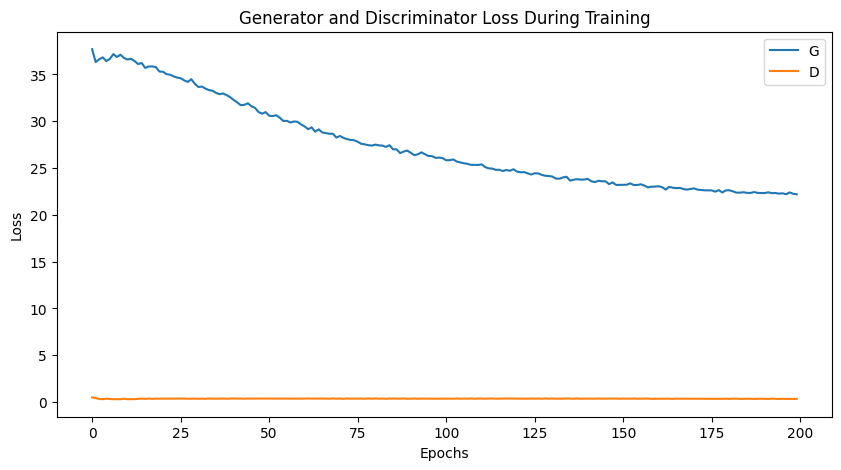

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


--- Generating final test images ---


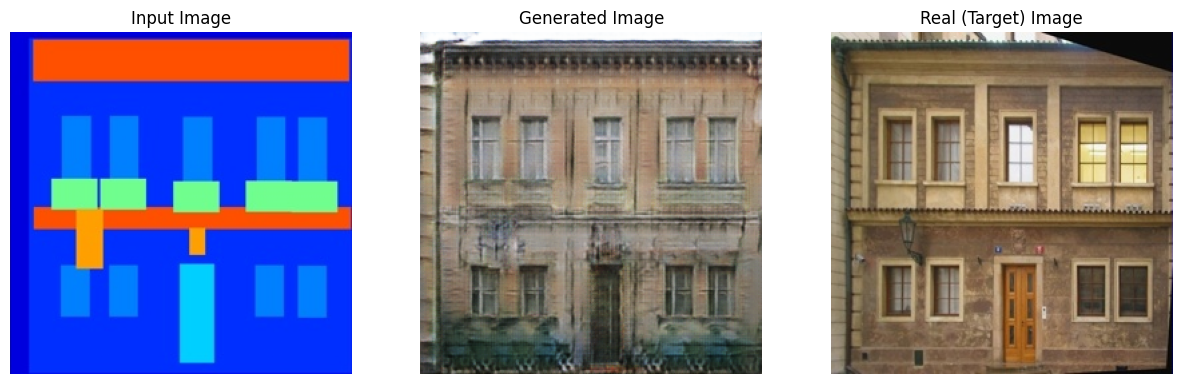

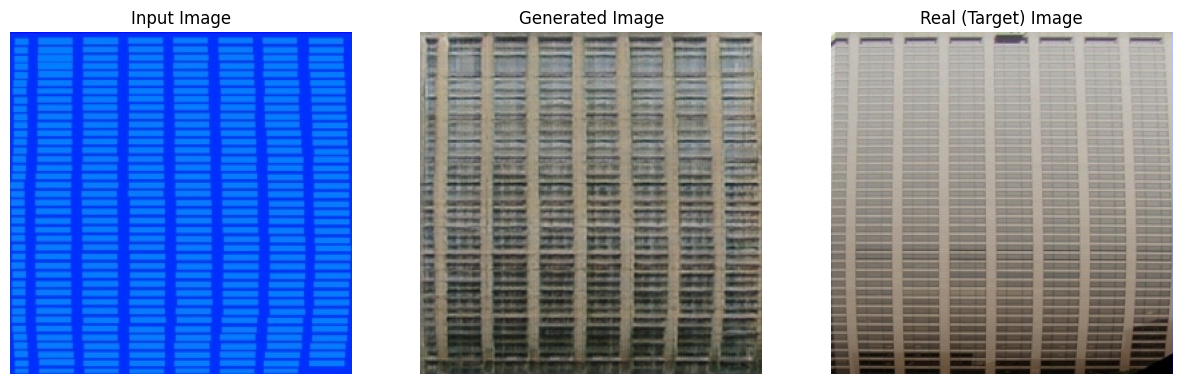

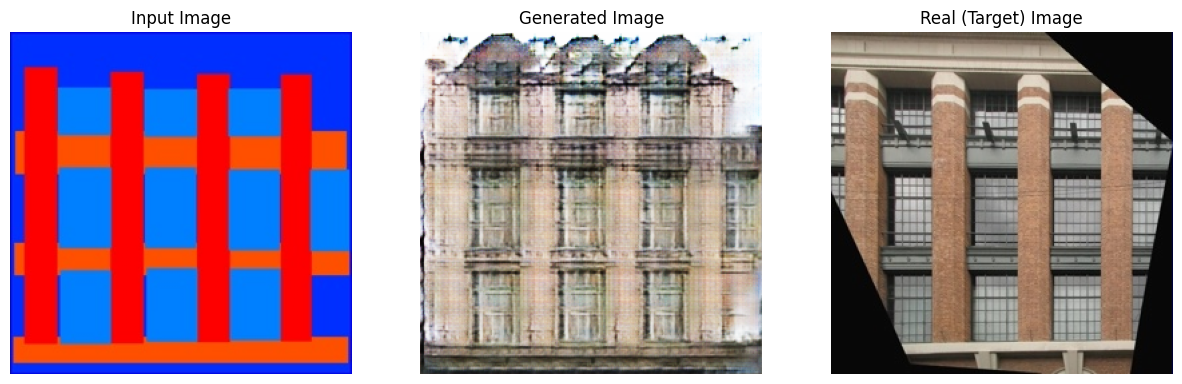

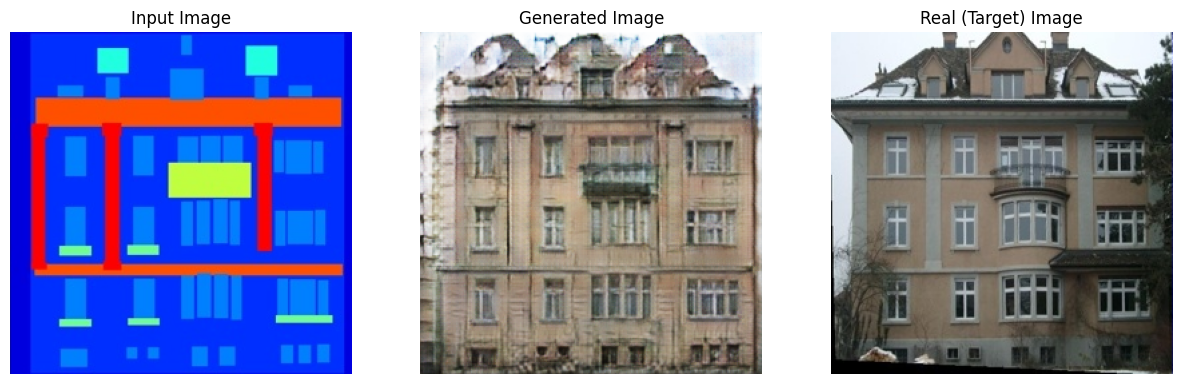

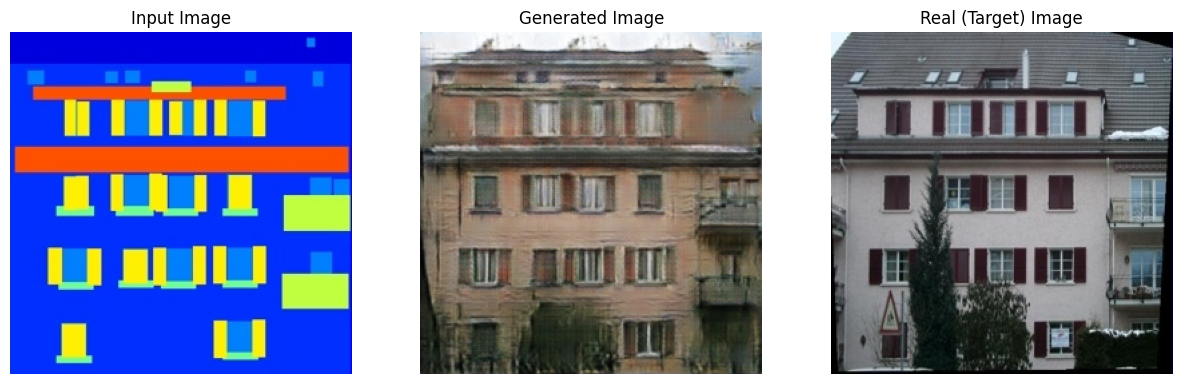

In [13]:
def plot_test_examples(gen_model, loader, num_to_plot=5):
    gen_model.eval() # Set to evaluation mode
    print("\n--- Generating final test images ---")
    
    with torch.no_grad():
        for i, (input_img, target_img) in enumerate(loader):
            if i >= num_to_plot:
                break
                
            input_img, target_img = input_img.to(cfg.DEVICE), target_img.to(cfg.DEVICE)
            
            # Generate fake image
            fake_img = gen_model(input_img)
            
            # Denormalize from [-1, 1] to [0, 1]
            input_img_plot = (input_img * 0.5 + 0.5).cpu().squeeze()
            target_img_plot = (target_img * 0.5 + 0.5).cpu().squeeze()
            fake_img_plot = (fake_img * 0.5 + 0.5).cpu().squeeze()

            # Plot
            plt.figure(figsize=(15, 5))
            
            # Transpose from (C, H, W) to (H, W, C) for matplotlib
            plt.subplot(1, 3, 1)
            plt.imshow(input_img_plot.permute(1, 2, 0))
            plt.title("Input Image")
            plt.axis("off")
            
            plt.subplot(1, 3, 2)
            plt.imshow(fake_img_plot.permute(1, 2, 0))
            plt.title("Generated Image")
            plt.axis("off")
            
            plt.subplot(1, 3, 3)
            plt.imshow(target_img_plot.permute(1, 2, 0))
            plt.title("Real (Target) Image")
            plt.axis("off")
            
            plt.show()
            
    gen_model.train() # Set back to train mode

# --- Run the final testing ---
plot_test_examples(gen, val_loader, num_to_plot=5)

In [14]:
# --- 1. Create a checkpoints directory ---
os.makedirs("checkpoints", exist_ok=True)

# --- 2. Save the Generator's state dictionary ---
save_path = "checkpoints/pix2pix_generator.pth"
torch.save(gen.state_dict(), save_path)

print(f"Generator model saved to: {save_path}")

Generator model saved to: checkpoints/pix2pix_generator.pth


In [15]:
# --- 1. Re-define the Generator class ---
# (You must have the class definition available in your script)
# (In your notebook, just make sure Cell 6 has been run)
print("Generator class definition is ready.")


# --- 2. Instantiate a new generator ---
loaded_gen = Generator(in_channels=3, out_channels=3).to(cfg.DEVICE)


# --- 3. Load the saved weights ---
load_path = "checkpoints/pix2pix_generator.pth"
loaded_gen.load_state_dict(torch.load(load_path))


# --- 4. Set the model to evaluation mode ---
# This is crucial! It disables things like Dropout.
loaded_gen.eval()

print(f"Generator model loaded from: {load_path}")

Generator class definition is ready.
Generator model loaded from: checkpoints/pix2pix_generator.pth


Translating image: D:\ProdigyInfotechInternship\Task4\PRDOIGY_GA_04\data\facades\facades\val\1.jpg


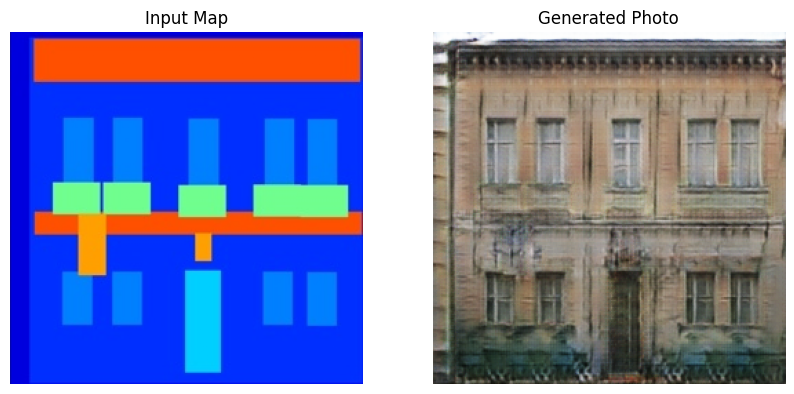

In [16]:
def translate_image(model, image_path):
    # --- 1. Load the single image file ---
    image = Image.open(image_path).convert("RGB")
    
    # --- 2. Extract the input map (the right side) ---
    width, height = image.size
    input_map = image.crop((width // 2, 0, width, height))
    real_photo = image.crop((0, 0, width // 2, height)) # For comparison

    # --- 3. Apply the validation (test) transforms ---
    # We use val_transform because we don't want random jitter
    input_tensor = val_transform(input_map).to(cfg.DEVICE)
    
    # --- 4. Add a batch dimension (B, C, H, W) ---
    # The model expects a batch, so (3, 256, 256) -> (1, 3, 256, 256)
    input_tensor = input_tensor.unsqueeze(0) 

    # --- 5. Run inference ---
    with torch.no_grad(): # We don't need to calculate gradients
        generated_tensor = model(input_tensor)
    
    # --- 6. Post-process the images for plotting ---
    # Remove batch dimension
    input_map_plot = input_tensor.squeeze(0).cpu()
    generated_img_plot = generated_tensor.squeeze(0).cpu()
    
    # Denormalize from [-1, 1] to [0, 1]
    input_map_plot = input_map_plot * 0.5 + 0.5
    generated_img_plot = generated_img_plot * 0.5 + 0.5
    
    # --- 7. Plot the results ---
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(input_map_plot.permute(1, 2, 0))
    plt.title("Input Map")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(generated_img_plot.permute(1, 2, 0))
    plt.title("Generated Photo")
    plt.axis("off")
    
    plt.show()

# --- Try it on an image from the validation set ---
# Get the path to the first image in the 'val' directory
test_img_name = os.listdir(cfg.VAL_DIR)[0]
test_img_path = os.path.join(cfg.VAL_DIR, test_img_name)

print(f"Translating image: {test_img_path}")
translate_image(loaded_gen, test_img_path)